# Test Functional Coherence of GO Terms in Clusters

In [1]:
from itertools import combinations
from loguru import logger

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import jaccard
from scipy.stats import ttest_ind
from tqdm import tqdm

from philharmonic.utils import (
    add_GO_function,
    load_cluster_json,
    parse_GO_database,
    parse_GO_map,
)

In [2]:
# Initial Files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.functional.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_GO_map.csv"
cluster_func_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_cluster_graph_functions.tsv"

GO_SLIM_PATH = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/goslim_generic.obo"
GO_FULL_PATH = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/go.obo"

from pathlib import Path
IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img/pdam")

# # Initial Files
# cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/20240926_cgoreaui_clusters.json"
# network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/20240926_cgoreaui_network.positive.tsv"
# go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/20240926_cgoreaui_GO_map.csv"

# GO_DATABASE = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/go.obo"
# GO_SLIM = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/goslim_generic.obo"

# from pathlib import Path
# IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img/cgor")

---

## Load Files

In [3]:
# Load clusters
cluster_dict = load_cluster_json(cluster_file_path)

In [4]:
USE_GO_SLIM = False

# Add GO Annotations
go_map = parse_GO_map(go_map_path)

if USE_GO_SLIM:
    go_db = parse_GO_database(GO_SLIM_PATH)
else:
    go_db = parse_GO_database(GO_FULL_PATH)

In [5]:
for clust in cluster_dict.values():
    clust["GO_terms"] = add_GO_function(clust, go_map, go_db=go_db)
    for gt in clust["GO_terms"].keys():
        assert gt in go_db.keys()

---

## Native Cluster Coherence

In [6]:
go_assigned = set()
for clust in tqdm(cluster_dict.values()):
    for m in clust["members"]:
        go_assigned.update(go_map.get(m, []))
go_assigned = sorted(list(go_assigned.intersection(go_db.keys())))

logger.info(f"{len(go_assigned)} GO terms assigned")

100%|██████████| 468/468 [00:00<00:00, 25777.21it/s]
2024-10-21 10:54:10.188 | INFO     | __main__:<module>:7 - 10799 GO terms assigned


In [7]:
proteins_in_clusters = []
for clust in tqdm(cluster_dict.values()):
    proteins_in_clusters.extend(clust["members"])
    proteins_in_clusters.extend(list(clust["recipe"]["degree"]["0.75"]))
logger.info(f"{len(proteins_in_clusters)} proteins in clusters")

100%|██████████| 468/468 [00:00<00:00, 624342.96it/s]
2024-10-21 10:54:10.195 | INFO     | __main__:<module>:5 - 12083 proteins in clusters


In [8]:
def protein_GO_bit_vector(
    protein_id, go_map, full_go_list, id_col="seq", go_col="GO_ids"
):
    go_bv = np.zeros(len(full_go_list))
    prot_go = go_map.get(protein_id)
    if prot_go is not None:
        for gid in prot_go:
            if gid in full_go_list:
                go_bv[full_go_list.index(gid)] = 1
    return go_bv

# Compute GO bit vectors for each protein
protein_GO_bvs = {}
for pid in tqdm(proteins_in_clusters):
    protein_GO_bvs[pid] = protein_GO_bit_vector(pid, go_map, go_assigned)

100%|██████████| 12083/12083 [01:51<00:00, 108.44it/s]


In [9]:
cluster_jaccards = {}

for k, clust in tqdm(cluster_dict.items()):
    cjaccard = []
    for p1, p2 in combinations(clust["members"] + list(clust["recipe"]["degree"]["0.75"]), 2):
        jc = 1 - jaccard(protein_GO_bvs[p1], protein_GO_bvs[p2])
        cjaccard.append(jc)
    cluster_jaccards[k] = np.array(cjaccard)

100%|██████████| 468/468 [00:03<00:00, 117.40it/s]


---

## Shuffled Cluster Coherence

In [10]:
rng = np.random.default_rng(seed=42)
shuffled_bit_vectors = {k: v for k, v in zip(protein_GO_bvs.keys(), rng.permutation(list(protein_GO_bvs.values())))}

In [11]:
cluster_jaccards_perm = {}

for k, clust in tqdm(cluster_dict.items()):
    cjaccard = []
    for p1, p2 in combinations(clust["members"] + list(clust["recipe"]["degree"]["0.75"]), 2):
        jc = 1 - jaccard(shuffled_bit_vectors[p1], shuffled_bit_vectors[p2])
        cjaccard.append(jc)
    cluster_jaccards_perm[k] = np.array(cjaccard)

100%|██████████| 468/468 [00:03<00:00, 120.22it/s]


--- 


## Compare shuffled and original coherence

In [12]:
phil_mean = [np.mean(i) for i in cluster_jaccards.values()]
permute_mean = [np.mean(i) for i in cluster_jaccards_perm.values()]
coherence_df = pd.DataFrame(
    {"cluster": list(cluster_jaccards.keys()), "PHILHARMONIC": phil_mean, "Random Clustering": permute_mean}
).melt("cluster").rename({"variable": "Clustering Method", "value": "Mean Jaccard Similarity"}, axis=1)
coherence_df.head()

,cluster,Clustering Method,Mean Jaccard Similarity
0,1820850722272676818,PHILHARMONIC,0.058390
1,1258033634750426039,PHILHARMONIC,0.073552
2,595187191250287510,PHILHARMONIC,0.020665
3,1953122705995928721,PHILHARMONIC,0.189681
4,871092547245650990,PHILHARMONIC,0.012595


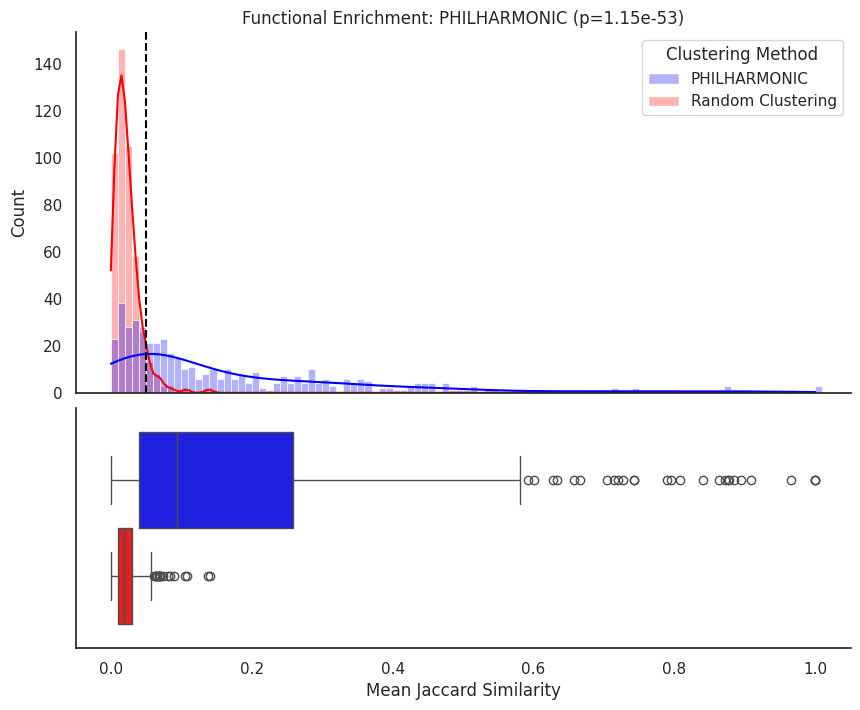

In [13]:
sns.set_palette("colorblind")
sns.set_theme(style="white", palette="pastel", font_scale=1)

# Create figure and gridspec
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 2], hspace=0.05)

# Create top subplot for histogram
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

sns.histplot(
    data=coherence_df,
    x="Mean Jaccard Similarity",
    hue="Clustering Method",
    alpha=0.3,
    bins=np.arange(0, 1.05, 0.01),
    kde=True,
    palette=["blue", "red"],
    common_norm=False,
    ec="white",
    ax=ax0
)

sns.boxplot(
    data=coherence_df,
    x="Mean Jaccard Similarity",
    hue="Clustering Method",
    palette=["blue", "red"],
    ax=ax1
)

ax0.set_xlabel('')  # Remove x-label from top plot
ax0.set_xticklabels([])  # Remove x-ticks from top plot

ax0.set_xlim(ax1.get_xlim()) # Align the x-axis of both subplots
ax1.get_legend().remove() # Remove legend from bottom plot

tstat, p = ttest_ind(phil_mean, permute_mean, alternative="greater")
ax0.set_title("Functional Enrichment: PHILHARMONIC (p={:.3})".format(p))

if USE_GO_SLIM:
    ax0.axvline(0.35, linestyle="--", color="black")
else:
    ax0.axvline(0.05, linestyle="--", color="black")

# Show the plot
sns.despine()
finame = "function_enrichment_combined_GOfull.svg" if not USE_GO_SLIM else "function_enrichment_combined_GOslim.svg"
plt.savefig(IMG_DIR / finame, bbox_inches="tight", dpi=300)
plt.show()

---
## Display Coherence by GO Slim Function

In [14]:

cluster_top_terms = pd.read_csv(cluster_func_path, sep="\t").set_index("key")

clens = [len(clust["members"]) for clust in cluster_dict.values()]
clen_bin = pd.cut(clens, bins=[0, 5, 10, 15, 20, 25, 30])
cjacc = [np.mean(cluster_jaccards[k]) for k in cluster_dict]
cfunc = [cluster_top_terms.loc[int(k),"go_fn"] for k in cluster_dict]
func_df = pd.DataFrame(
    {"Function": cfunc, "Mean Jaccard Similarity": cjacc, "Cluster Size": clens, }
)
func_df["Function"] = func_df["Function"].str.lower()
func_df = func_df.sort_values("Function")
func_df["Function"].fillna("No dominant function", inplace=True)

logger.info(f"Function dataframe shape: {func_df.shape}")

2024-10-21 10:56:10.345 | INFO     | __main__:<module>:14 - Function dataframe shape: (468, 3)


In [15]:
import xml.etree.ElementTree as ET

# Define the path to the XML file
xml_file_path = '../assets/philharmonic_styles.xml'

# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Extract colors from the "philharmonic" style
philharmonic_colors = {}
for style in root.findall(".//discreteMappingEntry"):
    name = style.get("attributeValue").lower()
    value = style.get("value")
    philharmonic_colors[name] = value

for f in func_df["Function"].unique():
    if f not in philharmonic_colors.keys():
        philharmonic_colors[f] = "#aaaaaa"

In [16]:
grouped_order = func_df.loc[:,['Function', 'Mean Jaccard Similarity']] \
    .groupby(['Function']) \
    .median() \
    .sort_values(by='Mean Jaccard Similarity')

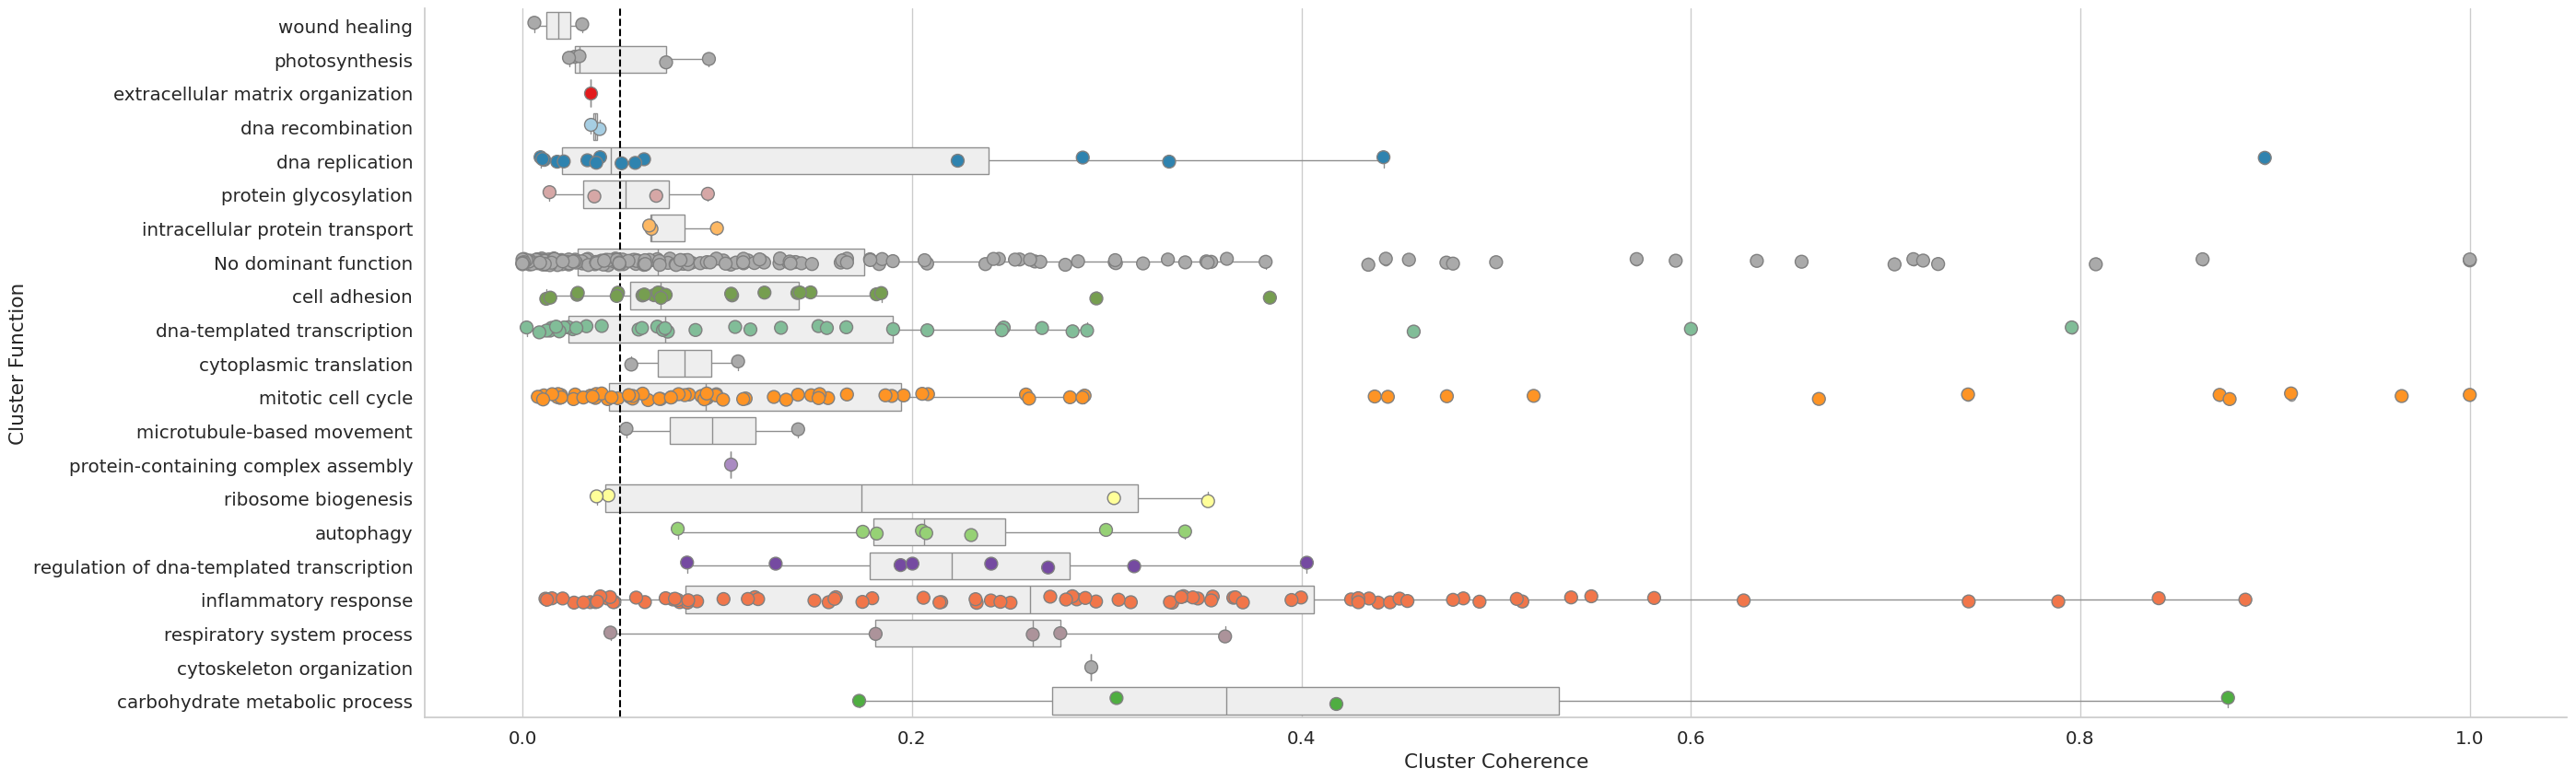

In [17]:
sns.set_theme(style="whitegrid", font_scale=1.3)
fig, ax = plt.subplots(figsize=(30, 10))

sns.stripplot(data=func_df, x="Mean Jaccard Similarity", y="Function", ax=ax, hue="Function", palette=philharmonic_colors,order=grouped_order.index,s=10, edgecolor="grey", linewidth=1)
sns.boxplot(data=func_df, x="Mean Jaccard Similarity", y="Function", ax=ax, hue="Function", palette={k:"#eeeeee" for k in func_df["Function"].unique()}, order=grouped_order.index)
plt.xlabel("Cluster Coherence")
plt.ylabel("Cluster Function")

if USE_GO_SLIM:
    ax.axvline(0.35, linestyle="--", color="black")
else:
    ax.axvline(0.05, linestyle="--", color="black")

sns.despine()
finame = "enrichment_by_function_swarmbox_GOfull.svg" if not USE_GO_SLIM else "enrichment_by_function_swarmbox_GOslim.svg"
plt.savefig(IMG_DIR / finame, bbox_inches="tight", dpi=300)
plt.show()